# Initialization

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from fastai.imports import *
from fastai.tabular import *
import fastaimisc
import seaborn as sns
from scipy.stats import norm
plt.style.use('seaborn-darkgrid')

Load the data

In [2]:
# loading the data set and test set
df_raw = pd.read_csv('train.csv',index_col='Id')
df_train = pd.read_csv('train.csv',index_col='Id')
df_test = pd.read_csv('test.csv',index_col='Id')

# drop SalePrice
#df_train_raw.drop('SalePrice',axis=1, inplace=True)

# concatenate data frames
#df_tot = pd.concat([df_train,df_test])
#display_all(df_raw)
#display(df_train_raw)
#display(df_test_raw)


In [3]:
df_train.SalePrice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

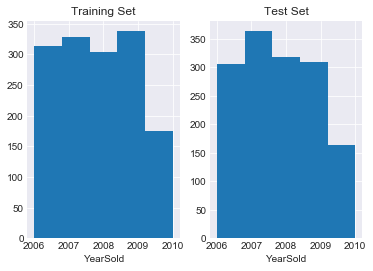

In [4]:
plt.subplot(1, 2, 1)
plt.hist(df_train.YrSold,5)
plt.title('Training Set')
plt.xlabel('YearSold')
plt.subplot(1, 2, 2)
plt.hist(df_test.YrSold,5)
plt.title('Test Set')
plt.xlabel('YearSold')
plt.show()

# Outlier Cleaning

According to Dean de Cock, the data set contains five outliers with *GrLivArea* > 4000: two large houses with accordingly high prices and three large houses with unsusually low prices (partial sales). 

In [5]:
outlierID_train = df_train[ df_train.GrLivArea > 4000].index
outlierID_test = df_test[ df_test.GrLivArea > 4000].index

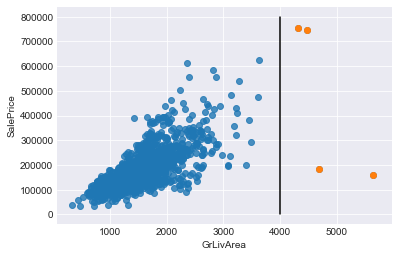

Id
2550    5095
Name: GrLivArea, dtype: int64


In [6]:
fig,ax = plt.subplots()
ax.scatter(df_train.GrLivArea,df_train.SalePrice,alpha=0.8)
ax.scatter(df_train.GrLivArea[df_train.GrLivArea>4000],df_train.SalePrice[df_raw.GrLivArea>4000])
ax.plot([4000,4000],[0,8*10**5],color='black')
plt.xlabel('GrLivArea', size=10)
plt.ylabel('SalePrice', size=10)
plt.show()

print(df_test.GrLivArea[df_test.GrLivArea>4000])

We see that the training set contains four of those houses but only two partial sales. Thus, the test set must contain the last partial sale. We will later set its predicted value to the average of the two other partial sales.

In [7]:
df_train.loc[(df_train.GrLivArea > 4000) & (df_train.SalePrice < 3*10**5)]

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
Id,,,,,,,,,,,,,,,,,,,,,
524,60,RL,130.0,40094,Pave,NaN,IR1,Bnk,AllPub,Inside,...,0,NaN,NaN,NaN,0,10,2007,New,Partial,184750
1299,60,RL,313.0,63887,Pave,NaN,IR3,Bnk,AllPub,Corner,...,480,Gd,NaN,NaN,0,1,2008,New,Partial,160000


We record the average *SalePrice* for the partial sales and drop the outliers from the training set.

In [8]:
outlier_predicted_price = df_train.loc[(df_train.GrLivArea > 4000) & (df_train.SalePrice < 3*10**5)].SalePrice.mean()
df_train.drop(outlierID_train,inplace=True)
df_raw.drop(outlierID_train,inplace=True)

In [9]:
y_target = np.log(df_train.SalePrice)
print('y_target set as log-SalePrice')
df_train.drop('SalePrice',axis=1,inplace=True)
print('Dependent variable dropped from training set.')

y_target set as log-SalePrice
Dependent variable dropped from training set.


# Missing Values

In [10]:
df_tot = pd.concat([df_train,df_test])

We first fill in those missing values that actually indicate the absence of a feature. This is given in the description of the data set. We fill in the value *NotAv* for these values.

In [11]:
# Figure out missing values
list_missing_values = ['Alley','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinType2',
                       'FireplaceQu','GarageType','GarageFinish','GarageQual','GarageCond',
                      'PoolQC','Fence','MiscFeature']
for val in list_missing_values:
    df_tot.fillna(value={val:'NotAv'},inplace=True)


Next, we investigate the true missing values.

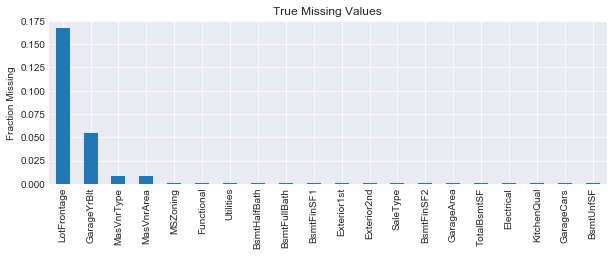

In [12]:
df_tot_missing = df_tot.isnull().mean()[df_tot.isnull().any()]
df_tot_missing.sort_values(ascending=False).plot.bar(figsize=(10,3))
plt.title('True Missing Values')
plt.ylabel('Fraction Missing')
plt.show()

We move from top to bottom. The first thing to tackle is *LotFrontage*

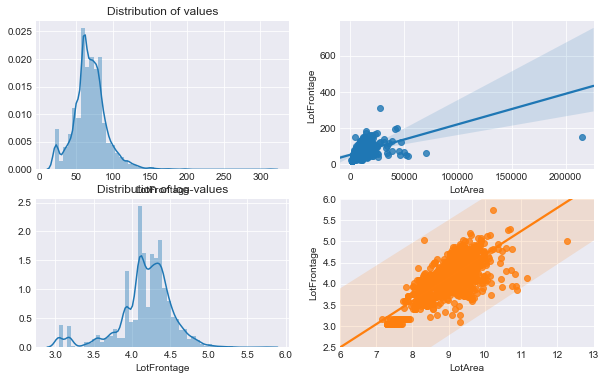

In [13]:
fig,ax = plt.subplots(ncols=2,nrows=2,figsize=(10,6))
sns.distplot(df_tot.LotFrontage[df_tot.LotFrontage.notnull()],ax=ax[0][0])
ax[0][0].set_title('Distribution of values')
sns.regplot(x='LotArea',y='LotFrontage',
            data=df_tot.loc[df_tot.LotFrontage.notnull(),['LotArea', 'LotFrontage']],ax=ax[0][1])
sns.distplot(df_tot.LotFrontage[df_tot.LotFrontage.notnull()].apply(np.log),ax=ax[1][0])
ax[1][0].ticklabel_format(style='sci', axis='x', scilimits=(0,0))
ax[1][0].set_title('Distribution of log-values')
sns.regplot(x='LotArea',y='LotFrontage',
            data=df_tot.loc[df_tot.LotFrontage.notnull(),['LotArea', 'LotFrontage']].apply(np.log),ax=ax[1][1])
ax[1][1].set_xlim(6, 13)
ax[1][1].set_ylim(2.5, 6)

plt.show()

In [14]:
from sklearn.linear_model import LinearRegression
tmp = pd.get_dummies(df_tot[['LotFrontage','LotArea', 'LotConfig', 'Neighborhood']])
tmp.loc[:,['LotArea','LotFrontage']] = np.log(tmp.loc[:,['LotArea','LotFrontage']])
tmp
#display(tmp.dropna()['LotFrontage'])
#display(np.log(tmp.dropna().drop('LotArea',axis=1)))
#tmp.dropna().drop('LotFrontage', axis=1)
tmpreg = LinearRegression()
tmpreg.fit(tmp.dropna().drop('LotFrontage',axis=1),tmp.dropna()['LotFrontage'])

print('R2 of the regression: {:.2f}'.format(
    tmpreg.score(tmp.dropna().drop('LotFrontage', axis=1), tmp.dropna()['LotFrontage']))
     )
#tmp3 = tmpreg.predict(tmp.loc[tmp.isnull().any(axis=1),['LotArea']])
tmp3 = tmpreg.predict(tmp.loc[tmp.isnull().any(axis=1)].drop('LotFrontage',axis=1))
df_tot.loc[df_tot.LotFrontage.isnull(),'LotFrontage'] = np.exp(tmp3)

R2 of the regression: 0.71


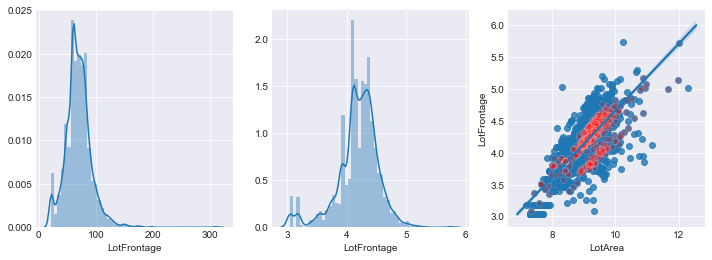

In [15]:
fig,ax = plt.subplots(ncols=3,nrows=1,figsize=(12,4))
sns.distplot(df_tot.LotFrontage[df_tot.LotFrontage.notnull()],ax=ax[0])
sns.distplot(df_tot.LotFrontage[df_tot.LotFrontage.notnull()].apply(np.log),ax=ax[1])
sns.regplot(x='LotArea',y='LotFrontage',
            data=pd.concat([df_tot.loc[df_tot.LotFrontage.notnull(),'LotArea'].apply(np.log),
           df_tot.loc[df_tot.LotFrontage.notnull(),'LotFrontage'].apply(np.log)], axis=1, sort=False),ax=ax[2])
#sns.scatter(pd.concat([df_tot.loc[df_tot.LotFrontage.notnull(),'LotArea'].apply(np.log),
#           df_tot.loc[df_tot.LotFrontage.notnull(),'LotFrontage'].apply(np.log),ax=ax[2])
sns.scatterplot(x=tmp.loc[tmp.isnull().any(axis=1)]['LotArea'],y=tmp3,color='red',alpha=0.2,ax=ax[2])         
plt.show()


We next look at the missing values considering the different garage properties. We see that there are many missing values for *GarageYrBlt*, but only one each for *GarageCars* and *GarageArea*. The latter two actually belong to the same house. 

In [16]:
display(df_tot.loc[df_tot.GarageArea.isnull(),['GarageArea','GarageCars','GarageType','GarageYrBlt','YearBuilt']])

,GarageArea,GarageCars,GarageType,GarageYrBlt,YearBuilt
Id,,,,,
2577,NaN,NaN,Detchd,NaN,1923


This house seems to have a garage since is has *GarageType = Detchd*. There are quite a few houses in the same neighborhood with a similar age and the same garage type. Thus, we will in the missing values for GarageArea, GarageYrBlt and GarageCars with the median of those values 

In [17]:
tmp = df_tot.loc[df_tot.GarageYrBlt.isnull() & (df_tot.GarageCars.isnull()) & (df_tot.GarageArea.isnull())].index
#display(df_tot.loc[(df_tot.GarageType == df_tot.loc[tmp[0],'GarageType']) & (df_tot.Neighborhood == df_tot.loc[tmp[0],'Neighborhood']),['GarageArea','GarageType','GarageCars','GarageCond','Neighborhood','GarageYrBlt','YearBuilt','YearRemodAdd']])
df_tot.loc[tmp[0],'GarageArea'] = df_tot.loc[(df_tot.GarageType == df_tot.loc[tmp[0],'GarageType']) & (df_tot.Neighborhood == df_tot.loc[tmp[0],'Neighborhood']),'GarageArea'].median()
df_tot.loc[tmp[0],'GarageCars'] = df_tot.loc[(df_tot.GarageType == df_tot.loc[tmp[0],'GarageType']) & (df_tot.Neighborhood == df_tot.loc[tmp[0],'Neighborhood']),'GarageCars'].median()
df_tot.loc[tmp[0],'GarageYrBlt'] = df_tot.loc[(df_tot.GarageType == df_tot.loc[tmp[0],'GarageType']) & (df_tot.Neighborhood == df_tot.loc[tmp[0],'Neighborhood']),'GarageYrBlt'].median()
display(df_tot.loc[tmp,['GarageArea','GarageCars','GarageYrBlt']])
print('Missing vals for GarageCars and GarageArea fixed.')

,GarageArea,GarageCars,GarageYrBlt
Id,,,
2577,314.0,1.0,1946.0


Missing vals for GarageCars and GarageArea fixed.


Next, we tackle the *GarageYrBlt*. Since *GarageCars* has no missing values, we can plot the histogram for the size of the garages for the missing values.

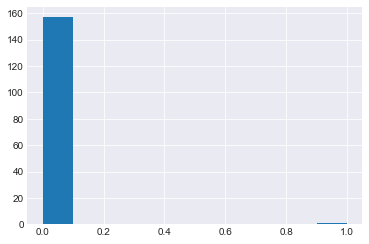

In [18]:
df_tot.loc[df_tot.GarageYrBlt.isnull(),'GarageCars'].hist()
plt.show()

Except for one house, all missing values relate to houses without a Garage. For these, we simply set *GarageYrBlt* equal to zero.

In [19]:
df_tot.loc[df_tot.GarageYrBlt.isnull() & (df_tot.GarageCars == 0),'GarageYrBlt'] = 0
print('GarageYrBlt fixed for missing Garage.')

GarageYrBlt fixed for missing Garage.


In [20]:
df_tot.loc[df_tot.GarageYrBlt.isnull()].GarageCars

Id
2127    1.0
Name: GarageCars, dtype: float64

Next, we fix the *GarageYrBlt* for the one observation that has a Garage but is missing the *GarageYrBlt* feature.
This house was built in 1910. As a (hopefully) reasonable guess, we set its GarageYrBlt to the average value for those houses in the same neighborhood that were build before 1950 and have the same type of garage.

In [21]:
tmp = df_tot.loc[df_tot.GarageYrBlt.isnull() & (df_tot.GarageCars > 0)].index
display(df_tot.loc[tmp[0]][['YearBuilt','MSSubClass','MSZoning','Neighborhood','GarageType','GarageCars','GarageCond']])
#[['GarageFinish','GarageCars','GarageQual','YearBuilt','YearRemodAdd']]
df_tot.loc[tmp[0],'GarageYrBlt'] = round(df_tot.loc[(df_tot.YearBuilt < 1950) & (df_tot.GarageType == 'Detchd') & (df_tot.Neighborhood == 'OldTown')]['GarageYrBlt'].mean())

display(df_tot.loc[tmp[0]][['GarageYrBlt']])

print('Missing vals for GarageYrBlt fixed.')

YearBuilt          1910
MSSubClass           60
MSZoning             RM
Neighborhood    OldTown
GarageType       Detchd
GarageCars            1
GarageCond        NotAv
Name: 2127, dtype: object

GarageYrBlt    1949
Name: 2127, dtype: object

Missing vals for GarageYrBlt fixed.


Last, we discover that there is a clear mistake in the *GarageYrBlt* data since on garage seems to have been built far away in the future. We correct this mistake and set the value equal to the value of *YearBuilt*.

In [22]:
tmp = df_tot.loc[df_tot['GarageYrBlt'] > 2100].index
df_tot.loc[tmp[0],'GarageYrBlt']  = df_tot.loc[tmp[0],'YearBuilt'] 

The next class is *MasVnrType* and *MasVnrArea*. Before considering the missing values, we do a sanity check for the remaining values since we should have *MasVnrArea* = 0 for *MasVnrType* = None.
We see that this is not always the case.

In [23]:
display(df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.MasVnrArea > 0),['MasVnrType','MasVnrArea']])
display(df_tot.loc[(df_tot.MasVnrType != 'None') & (df_tot.MasVnrArea == 0),['MasVnrType','MasVnrArea']])

,MasVnrType,MasVnrArea
Id,,
625,None,288.0
774,None,1.0
1231,None,1.0
1301,None,344.0
1335,None,312.0
1670,None,285.0
2453,None,1.0


,MasVnrType,MasVnrArea
Id,,
689,BrkFace,0.0
1242,Stone,0.0
2320,BrkFace,0.0


We believe that for *MasVnrType* = None and *MasVnrArea* = 1, the latter area should be zero. Further, if both values are missing, we assume that no masonry veneer exists and set it to None and 0, repsectively. For the houses with  *MasVnrArea* = 0 but a given *MasVnrType*, we set the area equal to the median of the houses with the same type in the same neighborhood. Similarly, for a given area but missing type, we replace this with the mode of those houses in the same neighborhood.

In [24]:
# Absences of masonry veneer
df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.MasVnrArea < 10),'MasVnrArea'] = 0
#
masvnr_missing_ID = df_tot.loc[df_tot.MasVnrType.isnull() & df_tot.MasVnrArea.isnull()].index
df_tot.loc[masvnr_missing_ID,'MasVnrArea'] = 0
df_tot.loc[masvnr_missing_ID,'MasVnrType'] = 'None'    


# Fill missing MasVnrArea
for tmpind in df_tot.loc[(df_tot.MasVnrType == 'Stone') & (df_tot.MasVnrArea < 10),'MasVnrArea'].index:
    df_tot.loc[tmpind,'MasVnrArea'] = df_tot.loc[(df_tot.Neighborhood == df_tot.loc[tmpind,'Neighborhood']) & (df_tot.MasVnrType == 'Stone'),'MasVnrArea'].median()
for tmpind in df_tot.loc[(df_tot.MasVnrType == 'BrkFace') & (df_tot.MasVnrArea < 10),'MasVnrArea'].index:
    df_tot.loc[tmpind,'MasVnrArea'] = df_tot.loc[(df_tot.Neighborhood == df_tot.loc[tmpind,'Neighborhood']) & (df_tot.MasVnrType == 'BrkFace'),'MasVnrArea'].median()

# Fill missing MasVnrType
for tmpind in df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.MasVnrArea > 10),'MasVnrArea'].index:
    df_tot.loc[tmpind,'MasVnrType'] = df_tot.loc[(df_tot.Neighborhood == df_tot.loc[tmpind,'Neighborhood']) & (df_tot.MasVnrType != 'None'),'MasVnrType'].mode()[0]
for tmpind in df_tot.loc[df_tot.MasVnrType.isnull() & (df_tot.MasVnrArea > 10),'MasVnrArea'].index:
    df_tot.loc[tmpind,'MasVnrType'] = df_tot.loc[(df_tot.Neighborhood == df_tot.loc[tmpind,'Neighborhood']) & (df_tot.MasVnrType != 'None'),'MasVnrType'].mode()[0]


print('Missing vals for MasVnrArea and MasVnrType fixed.')    

Missing vals for MasVnrArea and MasVnrType fixed.


Next is *MSZoning*. Here, we set the missing values to be the mode of the neighborhood.

In [25]:
for tmp_ind in df_tot.loc[df_tot.MSZoning.isnull()].index:
    df_tot.loc[tmp_ind,'MSZoning'] = df_tot.loc[df_tot.Neighborhood == df_tot.loc[tmp_ind,'Neighborhood'],'MSZoning'].mode()[0]

print('Missing vals for MSZoning and MasVnrType fixed.')   

Missing vals for MSZoning and MasVnrType fixed.


For *Functional*, we set the missing values to be the mode of those houses with the same *OverallCond*.

In [26]:
for tmp_ind in df_tot.loc[df_tot.Functional.isnull()].index:
    df_tot.loc[tmp_ind,'Functional'] = df_tot.loc[df_tot.OverallCond == df_tot.loc[tmp_ind,'OverallCond'],'Functional'].mode()[0]



For the missing *BasementBath* values, we can easily determine that those houses do not have a basement. We set the number of bathrooms to zero.

In [27]:
display(df_tot.loc[tmp,['BsmtFullBath','BsmtHalfBath','BsmtUnfSF','TotalBsmtSF','BsmtFinSF1','BsmtFinSF2']])
df_tot.loc[df_tot.BsmtFullBath.isnull(),'BsmtFullBath'] = 0
df_tot.loc[df_tot.BsmtHalfBath.isnull(),'BsmtHalfBath'] = 0
print('Missing vals for BsmtHalfBath and BsmtFullBath fixed.')

,BsmtFullBath,BsmtHalfBath,BsmtUnfSF,TotalBsmtSF,BsmtFinSF1,BsmtFinSF2
Id,,,,,,
2593,0.0,0.0,963.0,1546.0,583.0,0.0


Missing vals for BsmtHalfBath and BsmtFullBath fixed.


For *Utilities*, only one house is not *AllPub*, we thus set the missing values to *AllPub*

Missing vals for Utilities fixed.


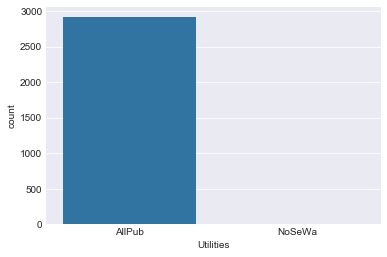

In [28]:
sns.countplot(x='Utilities',data=df_tot)
df_tot.loc[df_tot.Utilities.isnull(),'Utilities'] = 'AllPub'
print('Missing vals for Utilities fixed.')

For the missing *SaleType* entries, a histogram shows that most but not all houses were conventional warranty deed. We set the missing values equal to the mode of those houses in the same neighborhood.

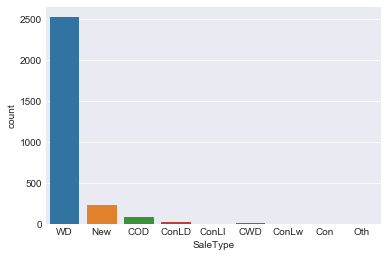

Missing vals for SaleType fixed.


In [29]:
sns.countplot(x='SaleType',data=df_tot)
plt.show()

for tmp_ind in df_tot.loc[df_tot.SaleType.isnull()].index:
    df_tot.loc[tmp_ind,'SaleType'] = df_tot.loc[df_tot.Neighborhood == df_tot.loc[tmp_ind,'Neighborhood'],'SaleType'].mode()[0]

print('Missing vals for SaleType fixed.')

For the missing *KitchenQual* value we look at those houses with the *same OverallQual*

Missing vals for KitchenQual fixed.


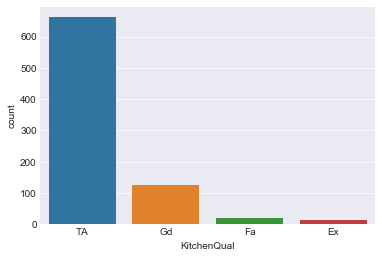

In [30]:
tmpqual = df_tot.loc[df_tot.KitchenQual.isnull(),'OverallQual'].values[0]
sns.countplot(x='KitchenQual',data=df_tot.loc[df_tot.OverallQual == tmpqual])
df_tot.loc[df_tot.KitchenQual.isnull(),'KitchenQual'] = df_tot.loc[df_tot.OverallQual == df_tot.loc[df_tot.loc[df_tot.KitchenQual.isnull()].index[0],'OverallQual'],'KitchenQual'].mode()[0]

print('Missing vals for KitchenQual fixed.')

For *Electrical*, we see that all modern houses have the same value and thus use that one.

Id
1380    2006
Name: YearBuilt, dtype: int64

Missing vals for Electrical fixed.


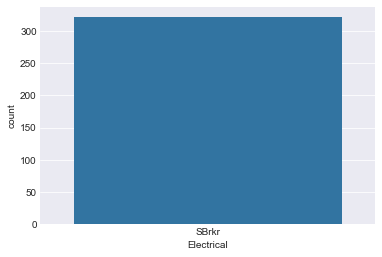

In [31]:
display(df_tot.loc[df_tot.Electrical.isnull(),'YearBuilt'])
sns.countplot(x='Electrical',data=df_tot.loc[df_tot.YearBuilt > 2005])
df_tot.loc[df_tot.Electrical.isnull(),'Electrical'] = df_tot.loc[df_tot.YearBuilt > 2005,'Electrical'].mode()[0]

print('Missing vals for Electrical fixed.')

There are a few missing values for the basement square feet describing variable. These relate to a single house that seems to have no basemend since *BsmtQual* is NotAv. We set those values to zero.

In [32]:
tmpind = df_tot.loc[df_tot.TotalBsmtSF.isnull(),['BsmtQual','BsmtCond','BsmtFinSF1','BsmtUnfSF']].index
df_tot.loc[tmpind[0],'TotalBsmtSF'] = 0
df_tot.loc[tmpind[0],'BsmtFinSF1'] = 0
df_tot.loc[tmpind[0],'BsmtFinSF2'] = 0
df_tot.loc[tmpind[0],'BsmtUnfSF'] = 0
print('Missing vals for Basement areas fixed.')

Missing vals for Basement areas fixed.


The last missing values are *Exterior1st* and *Exterior2nd*. We suppose that these are related to *RoofMatl* and the *MasVnrType* and set them to the mode of the houses with those same attributes.

,Exterior2nd,MasVnrType,ExterQual,Foundation,RoofMatl
Id,,,,,
2152,NaN,None,TA,PConc,Tar&Grv


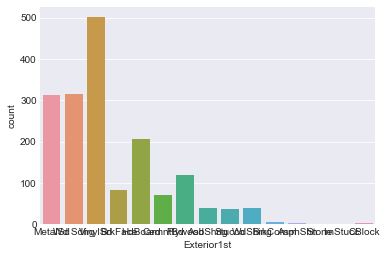

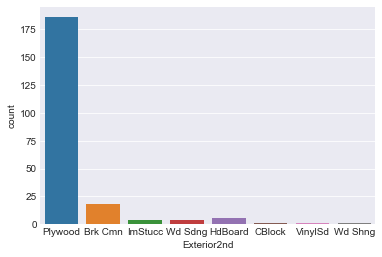

In [33]:

display(df_tot.loc[df_tot.Exterior1st.isnull(),['Exterior2nd','MasVnrType','ExterQual','Foundation','RoofMatl']])
sns.countplot(x='Exterior1st',data=df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.RoofMatl == df_tot.loc[tmpind[0],'RoofMatl'])])
plt.show()
sns.countplot(x='Exterior2nd',data=df_tot.loc[(df_tot.Exterior1st == 'Plywood')] )
plt.show()
#df_tot.loc[tmpind,'Exterior1st'] = 'Plywood'

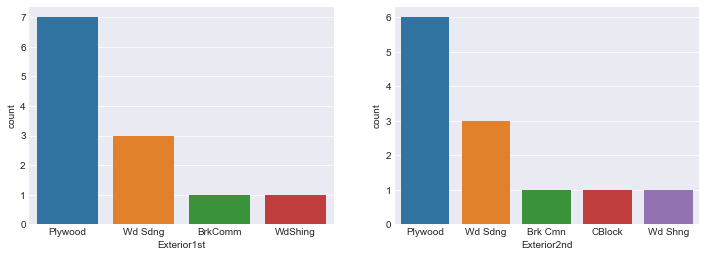

In [34]:
tmpind = df_tot.loc[df_tot.Exterior2nd.isnull(),['Exterior1st','MasVnrType','ExterQual','Foundation']].index
fig,ax = plt.subplots(ncols=2,nrows=1,figsize=(12,4))
sns.countplot(x='Exterior1st',data=df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.RoofMatl == df_tot.loc[tmpind[0],'RoofMatl'])],ax=ax[0])
sns.countplot(x='Exterior2nd',data=df_tot.loc[(df_tot.MasVnrType == 'None') & (df_tot.RoofMatl == df_tot.loc[tmpind[0],'RoofMatl'])],ax=ax[1])
plt.show()

df_tot.loc[tmpind,'Exterior1st'] = 'Plywood'
df_tot.loc[tmpind,'Exterior2nd'] = 'Plywood'


# Feature Engineering

First, we look at the categorical features that describe qualitative attributes. We map them to properly ordered numbers.

In [35]:
from sklearn.preprocessing import LabelEncoder

Qual_dict = {'Ex':5,'Gd':4,'TA':3,'Fa':2,'Po':1,'NotAv':0}
df_tot['BsmtQual'] = df_tot['BsmtQual'].map(Qual_dict)
df_tot['ExterQual'] = df_tot['ExterQual'].map(Qual_dict)
df_tot['ExterCond'] = df_tot['ExterCond'].map(Qual_dict)
df_tot['BsmtCond'] = df_tot['BsmtCond'].map(Qual_dict)
df_tot['HeatingQC'] = df_tot['HeatingQC'].map(Qual_dict)
df_tot['KitchenQual'] = df_tot['KitchenQual'].map(Qual_dict)
df_tot['FireplaceQu'] = df_tot['FireplaceQu'].map(Qual_dict)
df_tot['GarageQual'] = df_tot['GarageQual'].map(Qual_dict)
df_tot['GarageCond'] = df_tot['GarageCond'].map(Qual_dict)
df_tot['PoolQC'] = df_tot['PoolQC'].map(Qual_dict)
#
BsmtFinType1_dict = {'GLQ':6,'ALQ':5,'BLQ':4,'Rec':3,'LwQ':2,'Unf':1,'NotAv':0}
df_tot['BsmtFinType1'] = df_tot['BsmtFinType1'].map(BsmtFinType1_dict)
df_tot['BsmtFinType2'] = df_tot['BsmtFinType2'].map(BsmtFinType1_dict)




Next, we introduce two few new features: 
1. *AgeBuilt = YrSold - YearBuilt*
2. *AgeRemodAdd =  df_tot.YrSold - df_tot.YearRemodAdd*
3. *AgeGarage =  df_tot.YrSold - df_tot.GarageYrBlt*
4. *TotalIndrSF =  df_tot.TotalBsmtSF + df_tot.GrLivArea*

In [36]:
df_tot['AgeBuilt'] =  df_tot.YrSold - df_tot.YearBuilt
#df_tot['AgeRemodAdd'] =  df_tot.YrSold - df_tot.YearRemodAdd
#df_tot['AgeGarage'] =  df_tot.YrSold - df_tot.GarageYrBlt
df_tot['TotalIndrSF'] =  df_tot.TotalBsmtSF + df_tot.GrLivArea

Since *MSSubClass* has numerical entries without numerical meaning, we transform this into strings.

In [37]:
df_tot['MSSubClass'] = df_tot.MSSubClass.apply(str)


Last, we perform onehot encoding of the categorical variables. We then split the data set into training and test set and create a target variable from the logarithmic *SalePrice*.

In [38]:
df_tot_onehot = pd.get_dummies(df_tot)
df_train_processed = df_tot_onehot.iloc[:len(df_train),:]
df_test_processed = df_tot_onehot.iloc[len(df_train):,:]
y_target =  np.log(df_raw.SalePrice)

In [39]:
display(df_train_processed.describe())

,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,ExterQual,ExterCond,BsmtQual,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
count,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,1456.000000,1456.000000,1456.000000,1456.000000,1456.00000,...,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000,1456.000000
mean,70.256779,10448.784341,6.088599,5.576236,1971.18544,1984.819368,101.899038,3.392170,3.083791,3.48489,...,0.003434,0.082418,0.002060,0.868819,0.068681,0.002747,0.008242,0.013736,0.822115,0.084478
std,23.873988,9860.763449,1.369669,1.113966,30.20159,20.652143,177.113667,0.570206,0.351509,0.87409,...,0.058520,0.275094,0.045361,0.337715,0.252998,0.052360,0.090440,0.116434,0.382547,0.278199
min,21.000000,1300.000000,1.000000,1.000000,1872.00000,1950.000000,0.000000,2.000000,1.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,59.000000,7538.750000,5.000000,5.000000,1954.00000,1966.750000,0.000000,3.000000,3.000000,3.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,70.000000,9468.500000,6.000000,5.000000,1972.00000,1993.500000,0.000000,3.000000,3.000000,4.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,80.000000,11588.000000,7.000000,6.000000,2000.00000,2004.000000,164.250000,4.000000,3.000000,4.00000,...,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,313.000000,215245.000000,10.000000,9.000000,2010.00000,2010.000000,1600.000000,5.000000,5.000000,5.00000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Training a Basic Random Forest

We now train a random forest in order to get a baseline score of a simple regressor and to get insight about which features are important. First, we split the data into a training and validation set and define a function to compute the RMSE.

In [40]:
def split_vals(a,n): return a[:n].copy(), a[n:].copy()
X_train, X_val = split_vals(df_train_processed,1-round(len(df_train_processed)/10))
y_train, y_val = split_vals(y_target,1-round(len(df_train_processed)/10))

def get_rmse(x,y):
    """Compute RMSE for numerical inputs."""
    return np.sqrt( np.sum( (x-y)**2)/len(y))

Now we train a random forest regressor. We determined the parameters with a bit of trial and error since we're only looking for a reasonable but not yet a great model. The RMSE score would put us at about the middle of the leaderboard, so it's not a terrible model.

In [41]:
m2 = RandomForestRegressor(n_jobs=-1, n_estimators=1000,max_features=0.5,min_samples_leaf=3, oob_score=True)
m2.fit(X_train,y_train)
print('r2 score: ',m2.score(X_val,y_val))
print('RMSE: ',get_rmse(m2.predict(X_val),y_val))

r2 score:  0.8717520565915724
RMSE:  0.14415482584949388


# Feature Importance

In this section, we explore the importance of the different features in the leaderboard. To do this, we use the function *rf_feat_importance* from the fastai module. This function randomly shuffles one column at a time and determines how the prediction performance degrades. The idea is that the more the performance degrades for a given feature, the more important it is. This is explained [here](https://medium.com/@hiromi_suenaga/machine-learning-1-lesson-3-fa4065d8cb1e).

We see (perhaps unsurprisingly) that the most important features are the overall quality, the size, and the age of the house. A plot of all and of the 30 most important features further shows that the importance quickly degrades.

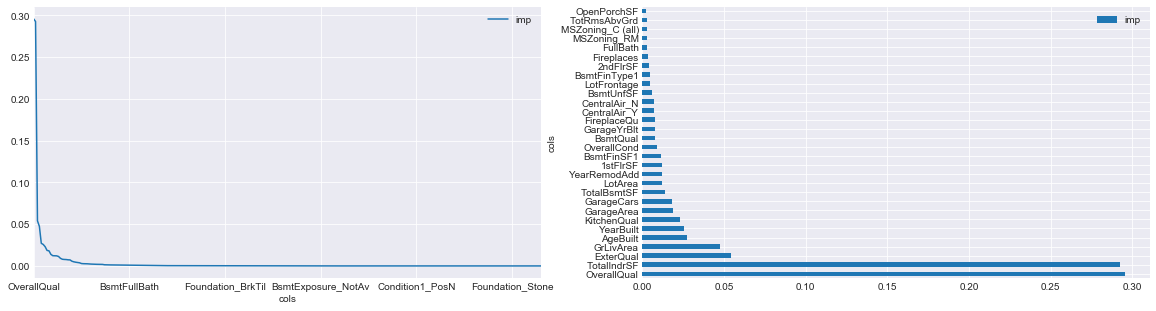

In [42]:
fi = fastaimisc.rf_feat_importance(m2,X_train); fi[:10]

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20,5))
fi.plot('cols','imp',ax=ax[0])
fi[:30].plot('cols','imp','barh',ax=ax[1])
plt.show()

Out of curiosity, we choose only the 25 (by this measure) most important features and train a new random forest. We see that the performance actually improves 

In [43]:
# RF
to_keep_RF = fi[fi.imp>0.004].cols; print(len(to_keep_RF))
df_keep_RF = df_train_processed[to_keep_RF].copy()
X_train_keep_RF,X_val_keep_RF = split_vals(df_keep_RF,1-round(len(df_keep_RF)/10))

m3 = RandomForestRegressor(n_jobs=-1, n_estimators=1000,max_features=0.5,min_samples_leaf=3, oob_score=True)
m3.fit(X_train_keep_RF,y_train)
print('All features r2 score: ',m2.score(X_val,y_val))
print('All features RMSE: ',(m2.predict(X_val)-y_val).std())
print('Trunc features r2 score: ',m3.score(X_val_keep_RF,y_val))
print('Trunc features RMSE: ',(m3.predict(X_val_keep_RF)-y_val).std())
print('Trunc features RMSE on training set: ',(m3.predict(X_train_keep_RF)-y_train).std())

24
All features r2 score:  0.8717520565915722
All features RMSE:  0.1438976419104884
Trunc features r2 score:  0.8765747875051677
Trunc features RMSE:  0.14130040075581918
Trunc features RMSE on training set:  0.07535321485632257


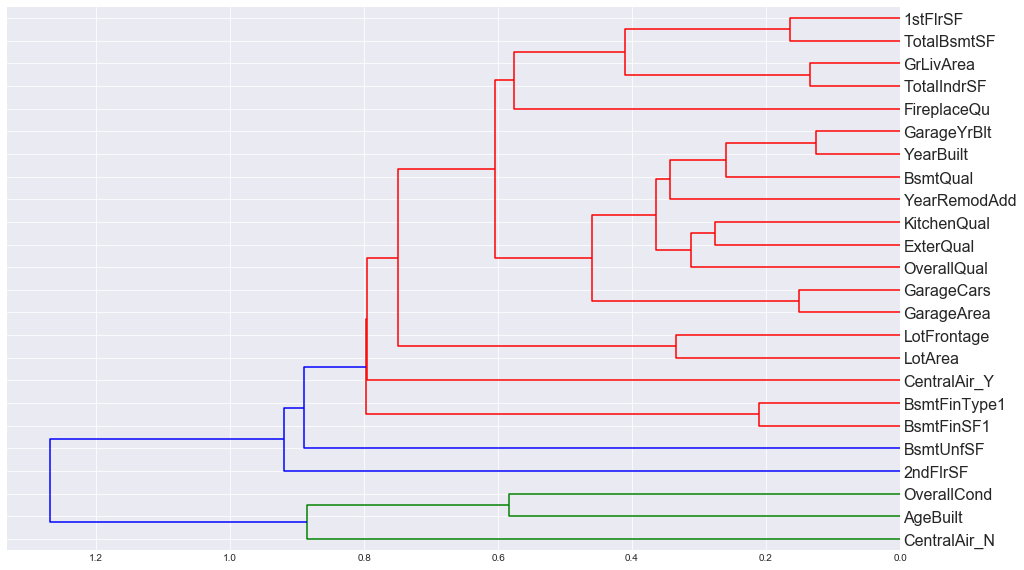

In [44]:
from scipy.cluster import hierarchy as hc
corr = np.round(scipy.stats.spearmanr(X_train_keep_RF).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=X_train_keep_RF.columns, 
      orientation='left', leaf_font_size=16)
plt.show()

# XGBoost

For simplicity, we take the XGB model parameters from this (https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard) notebook.

In [45]:
# XGBoost
import xgboost as xgb

xgb_reg = xgb.XGBRegressor(colsample_bytree = 0.4603, min_child_weight =1.71,
                          learning_rate = 0.05, reg_lambda = .85, subsample=0.52,
                          gamma = 0.046, max_depth = 3, n_estimators = 2200)




xgb_reg.fit(X_train,y_train)
print('RMSE: ',(xgb_reg.predict(X_val)-y_val).std())

/usr/local/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[14:18:50] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
RMSE:  0.13078053357353028


# Neural Network

In [46]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [47]:
# RF
to_keep_NN = fi[fi.imp>0.003].cols;
df_keep_NN = df_train_processed[to_keep_RF].copy()
X_train_keep_RF,X_val_keep_RF = split_vals(df_keep_RF,1-round(len(df_keep_RF)/10))

In [50]:
df_NN = df_tot_onehot[to_keep_NN].copy(); display(df_NN)

,OverallQual,TotalIndrSF,ExterQual,GrLivArea,AgeBuilt,YearBuilt,KitchenQual,GarageArea,GarageCars,TotalBsmtSF,...,BsmtQual,GarageYrBlt,FireplaceQu,CentralAir_Y,CentralAir_N,BsmtUnfSF,LotFrontage,BsmtFinType1,2ndFlrSF,Fireplaces
Id,,,,,,,,,,,,,,,,,,,,,
1,7,2566.0,4,1710,5,2003,4,548.0,2.0,856.0,...,4,2003.0,0,1,0,150.0,65.0,6,854,0
2,6,2524.0,3,1262,31,1976,3,460.0,2.0,1262.0,...,4,1976.0,3,1,0,284.0,80.0,5,0,1
3,7,2706.0,4,1786,7,2001,4,608.0,2.0,920.0,...,4,2001.0,3,1,0,434.0,68.0,6,866,1
4,7,2473.0,3,1717,91,1915,4,642.0,3.0,756.0,...,3,1998.0,4,1,0,540.0,60.0,5,756,1
5,8,3343.0,4,2198,8,2000,4,836.0,3.0,1145.0,...,4,2000.0,3,1,0,490.0,84.0,6,1053,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,4,1638.0,3,1092,36,1970,3,0.0,0.0,546.0,...,3,0.0,0,1,0,546.0,21.0,1,546,0
2916,4,1638.0,3,1092,36,1970,3,286.0,1.0,546.0,...,3,1970.0,0,1,0,294.0,21.0,3,546,0
2917,5,2448.0,3,1224,46,1960,3,576.0,2.0,1224.0,...,3,1960.0,3,1,0,0.0,160.0,5,0,1


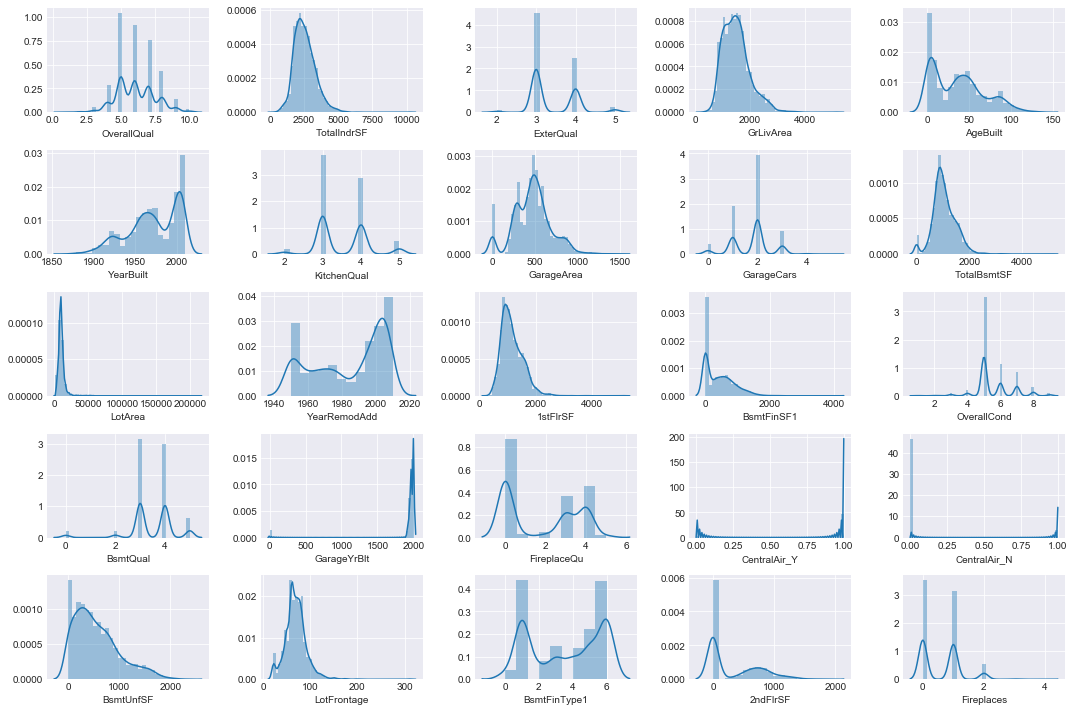

In [51]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,10))

for i, var in enumerate(df_NN):
    active_ax = ax.flatten()[i]
#    sns.distplot(df_NN.loc[df_NN[var] > 0, var], ax=active_ax)
    sns.distplot(df_NN[var], ax=active_ax)

fig.tight_layout()

In [ ]:
def log_normalize(df):
    df[df!=0] = np.log(df[df!=0])
    return (df - np.mean(df)) / np.std(df)

def lin_normalize(df):
    return (df - np.mean(df)) / np.std(df)

In [ ]:
list_lognorm = ['LotArea','MasVnrArea','BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF','1stFlrSF', '2ndFlrSF', 'LowQualFinSF','GrLivArea','GarageArea', 'WoodDeckSF', 'OpenPorchSF',
                'PoolArea', 'TotalIndrSF']

print('LotArea' in list_lognorm)

In [ ]:
df_NN['TotalIndrSF']

In [ ]:
for (col,data) in df_NN.iteritems():
    if col in list_lognorm:
        df_NN[col] = log_normalize(df_NN[col])
    else:
        df_NN[col] = lin_normalize(df_NN[col])

In [ ]:
fig, ax = plt.subplots(nrows=5, ncols=5, figsize=(15,10))

for i, var in enumerate(df_NN):
    active_ax = ax.flatten()[i]
    #sns.distplot(df_NN.loc[df_NN[var] > 0, var], ax=active_ax)
    sns.distplot(df_NN[var], ax=active_ax)

fig.tight_layout()

In [ ]:
df_train_NN = df_NN.iloc[:len(df_train),:]
df_test_NN = df_NN.iloc[len(df_train):,:]
y_target =  np.log(df_raw.SalePrice)
y_mean = y_target.mean()
y_std = y_target.std()
y_target_NN = (y_target-y_mean) / y_std

#X_train_NN, X_val = split_vals(df_train_NN,1-round(len(df_train_NN)/10))
X_train_NN, X_val_NN = split_vals(df_train_NN,1-round(len(df_train_NN)/10))
y_train_NN, y_val_NN = split_vals(y_target_NN,1-round(len(df_train_NN)/10))



In [ ]:
y_tensor = torch.from_numpy(np.array(y_train_NN)).float()
x_tensor = torch.from_numpy(np.array(X_train_NN)).float()
n_inputs = x_tensor.shape[1]
dataset = torch.utils.data.TensorDataset(x_tensor,y_tensor)
dataloader_NN = torch.utils.data.DataLoader(dataset,batch_size = x_tensor.size()[0])

#
y_tensor_val = torch.from_numpy(np.array(y_val_NN)).float()
x_tensor_val = torch.from_numpy(np.array(X_val_NN)).float()


In [ ]:

class Net(nn.Module):
    # initialize the network and define all learnable parameters
    def __init__(self):
        super(Net, self).__init__() # initialize properties and methods from parent class
        
        ###### add layers here ######
        self.h1  = nn.Linear(n_inputs,75, bias=True)
        self.h2  = nn.Linear(75,50, bias=True)
        self.h3  = nn.Linear(50,30, bias=True)
        self.h4 = nn.Linear(30, 15, bias=True)
        self.out = nn.Linear(15, 1, bias=True)        
        #############################
        
    # define the forward pass
    def forward(self, x):
        
        ###### code the forward computation ########
        x = F.relu(self.h1(x)) # First hidden layer
        x = F.relu(self.h2(x)) # Second hidden layer
        x = F.relu(self.h3(x))
        x = F.relu(self.h4(x))        
        out = self.out(x) # Output layer
        #############################
        return out



In [ ]:
# create a function (this my favorite choice)
def RMSELoss(yhat,y):
    return torch.sqrt(torch.mean((yhat.view(-1)-y)**2))

def train(NeuralNetwork,dataloader,loss_function, num_epochs, l_rate=0.001, wd=0,earlystop = True ):
    """
    Performs gradient descent learning.
    
    NeuralNetwork = neural network to be trained
    dataloader = DataLoader that deals batches for mini-batch learning
    loss_function = cost function to be optimized
    num_epochs = number of training epochs
    l_rate = learning rate (default value 0.001)
    wd = weight decay regularization (default value 0)
    """
    optimizer = torch.optim.SGD(NeuralNetwork.parameters(), lr = l_rate)
    validation_loss = math.inf
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for batch_idx , (inputs,labels) in enumerate(dataloader):
            # reset gradient
            optimizer.zero_grad()
            # forward propagation
            outputs = NeuralNetwork(inputs)
            # compute loss
            loss = torch.sqrt(loss_function(outputs, labels))
            # backprop
            loss.backward()
            # update parameters
            optimizer.step()
            # add loss
            running_loss += loss.item()
        if (epoch % 100) == 0:
            val_temp = validation_loss
            training_loss = RMSELoss(NeuralNetwork(x_tensor).detach()*y_std+y_mean,y_tensor*y_std+y_mean).numpy()
            validation_loss = RMSELoss(NeuralNetwork(x_tensor_val).detach()*y_std+y_mean,y_tensor_val*y_std+y_mean).numpy()
            print('Epoch: {0:5d} Training loss: {1:.4f}, Validation loss: {2:.4f}'.format(epoch,training_loss,validation_loss))
            if val_temp < validation_loss and earlystop:
                break

In [ ]:
net_reg = Net()
print(net_reg,'\n')

# Lets look at some example parameters of our network
params = list(net_reg.parameters())
print(params[0])

In [ ]:
train(net_reg,dataloader_NN,RMSELoss,10000, 0.01,wd=10**-5)

In [ ]:
predictions_NN = net_reg(x_tensor_val).detach().numpy().flatten()*y_std+y_mean
grid = np.linspace(0,1,21)
err_mixed = np.zeros(len(grid))
idx = 0 
for weight in np.linspace(0,1,21):
    err_mixed[idx] = get_rmse(xgb_reg.predict(X_val)*weight + (1-weight)*(predictions_NN),y_val)
    #print('Weight: ', weight,' RMSE: ',((xgb_reg.predict(X_val)*weight + (1-weight)*(predictions_NN))-y_val).std())
    idx += 1
idx_min = np.argmin(err_mixed)

fig,ax = plt.subplots()
ax.plot(grid,err_mixed)
ax.plot(grid[idx_min],err_mixed[idx_min],'ro')
plt.xlabel('Mixture weight of XGB')
plt.ylabel('RMSE')

plt.show()

# Training full NN

In [ ]:
net_final = Net()

y_tensor_full = torch.from_numpy(np.array(y_target_NN)).float()
x_tensor_full = torch.from_numpy(np.array(df_train_NN)).float()
n_inputs = x_tensor_full.shape[1]
dataset_full = torch.utils.data.TensorDataset(x_tensor_full,y_tensor_full)
dataloader_NN_full = torch.utils.data.DataLoader(dataset_full,batch_size = x_tensor_full.size()[0])

In [ ]:
train(net_final,dataloader_NN_full,RMSELoss,3000, 0.01,wd=10**-5, earlystop = False)
train(net_final,dataloader_NN_full,RMSELoss,1000, 0.001,wd=10**-5, earlystop = False)
#train(net_final,dataloader_NN,RMSELoss,5000, 10**-5,wd=5*10**-4, earlystop = False)
#train(net_final,dataloader_NN_full,RMSELoss,1000, 10**-6,wd=5*10**-4, earlystop = False)

In [ ]:
x_tensor_test = torch.from_numpy(np.array(df_test_NN)).float()
predictions_NN = net_reg(x_tensor_test).detach().numpy().flatten()*y_std+y_mean

# Training full XGB

In [ ]:
import xgboost as xgb
xg_full = xgb.XGBRegressor(colsample_bytree = 0.4603, min_child_weight = 1.71,
                          learning_rate = 0.05, reg_lambda = .85, subsample=0.52,
                          gamma = 0.046, max_depth = 3, n_estimators = 2200)
xg_full.fit(df_train_processed,y_target)





In [ ]:
predictions_XBG = xg_full.predict(df_test_processed)

# Putting Predictions Together

In [ ]:
outlier_test_ID = df_test_processed.loc[df_test_processed.GrLivArea > 4000].index[0]
df_pred = pd.DataFrame()
df_pred.insert(0,'SalePrice',np.exp(predictions_XBG*0.5 + predictions_NN*(1-.5)))
df_pred.insert(0,'Id',df_test_processed.index)
df_pred.loc[df_pred.Id == outlier_test_ID,'SalePrice'] = outlier_predicted_price
display(df_pred)
df_pred.to_csv('RF_v11.csv',index=False)